# Compare emfield_cartesian to Bmad

This compares tracking with various errors.

In [1]:
from pytao import Tao
import numpy as np
import os

from impact.interfaces.bmad import (
    impact_from_tao,
)
from pmd_beamphysics.fields.corrector_modeling import make_dipole_corrector_fieldmesh


import matplotlib.pyplot as plt

In [2]:
def make_test_lat(filename):
    lines = """
    no_digested
    beginning[beta_a] = 10
    beginning[beta_b] = 10
    beginning[e_tot] = 10e6
    parameter[geometry] = open
    parameter[particle] = electron
    
    HCOIL: em_field, L = 0.5,
        field_calc = fieldmap,
        tracking_method = runge_kutta,
        grid_field = call::correctorcoil_horizontal.h5
    HCOIL[FIELD_AUTOSCALE] = 0.1
    
    d1: drift, L = 0.5
    d2: drift, L = 0.5
    d3: drift, L = 1
    lat: line = (d1, HCOIL, d2)
    
    use, lat
    """
    with open(filename, "w") as f:
        f.write(lines)

In [3]:
def make_coil():
    R = 2 * 2.54e-2  # 2" radius [m]
    L = 0.1  # Length along z [m]
    theta = np.pi / 2  # Opening angle [rad]
    current = 100  # Current [Amp]

    fm = make_dipole_corrector_fieldmesh(
        current=current,
        xmin=-R,
        xmax=R,
        nx=51,
        ymin=-R,
        ymax=R,
        ny=51,
        zmin=-5 * L / 2,
        zmax=5 * L / 2,
        nz=51,
        mode="saddle",
        R=R,
        L=L,
        theta=theta,
        npts=20,
        plot_wire=False,
        tilt=0,
    )

    return fm


FM = make_coil()
FM.write("correctorcoil_horizontal.h5")

In [4]:
def make_and_track_impact(tao):
    p0c = tao.ele_orbit(0)["p0c"]
    i1 = impact_from_tao(tao)
    i1.track1(pz0=p0c)
    return i1

In [5]:
def compare_tao_impact(tao, i1):
    end = tao.ele_orbit("end")
    result = {}
    for key in ("x", "y"):
        impact_t = i1.output["stats"]["t"]
        impact_value = i1.output["stats"][f"mean_{key}"]
        result[f"impact_{key}"] = np.interp(end["t"], impact_t, impact_value)

        result[f"bmad_{key}"] = end[key]
    return result

In [6]:
def compare1(key, value, ele="HCOIL"):
    filename = "test_lat.bmad"
    make_test_lat(filename)

    tao = Tao(lattice_file=filename, noplot=True)

    tao.cmd(f"set ele {ele} {key} = {value}")

    # Make Impact
    i1 = make_and_track_impact(tao)

    return compare_tao_impact(tao, i1)

In [7]:
def scan1(key, values, ele="HCOIL"):
    results = [compare1(key, value, ele=ele) for value in values]
    table = {}
    for key in results[0]:
        table[key] = np.array([res[key] for res in results])
    return table

In [8]:
%%time
key = "tilt"
values = np.linspace(0, 0.01, 8)
table = scan1(key, values)
table["values"] = values
table["key"] = key

CPU times: user 9.28 s, sys: 237 ms, total: 9.51 s
Wall time: 13.2 s


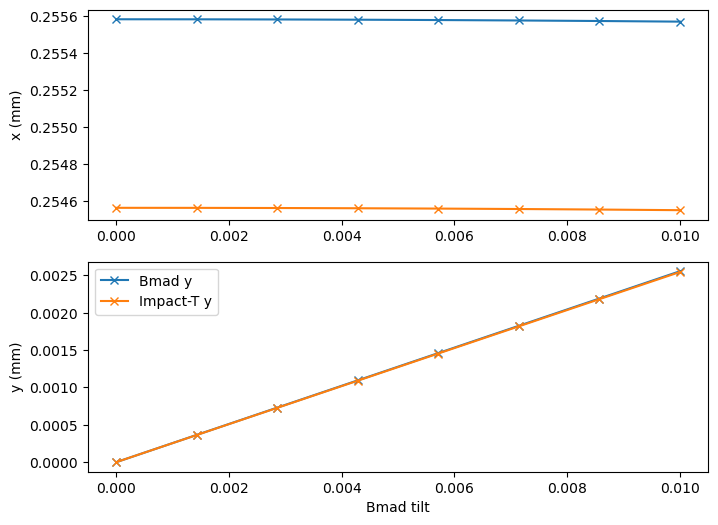

In [9]:
def plot_results(table):
    fig, axes = plt.subplots(2, figsize=(8, 6))
    axes[0].plot(values, 1e3 * table["bmad_x"], marker="x", label="Bmad x")
    axes[0].plot(values, 1e3 * table["impact_x"], marker="x", label="Impact-T x")
    axes[0].set_ylabel("x (mm)")

    axes[1].plot(values, 1e3 * table["bmad_y"], marker="x", label="Bmad y")
    axes[1].plot(values, 1e3 * table["impact_y"], marker="x", label="Impact-T y")
    axes[1].set_ylabel("y (mm)")

    axes[1].set_xlabel(f"Bmad {table['key']}")
    plt.legend()


plot_results(table)

CPU times: user 9.19 s, sys: 308 ms, total: 9.5 s
Wall time: 13.2 s


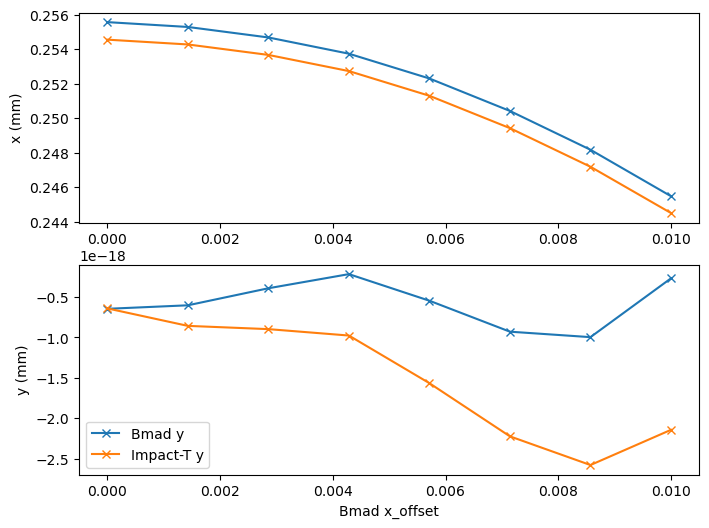

In [10]:
%%time
key = "x_offset"
values = np.linspace(0, 0.01, 8)
table = scan1(key, values)
table["values"] = values
table["key"] = key
plot_results(table)

CPU times: user 9.21 s, sys: 244 ms, total: 9.45 s
Wall time: 13.1 s


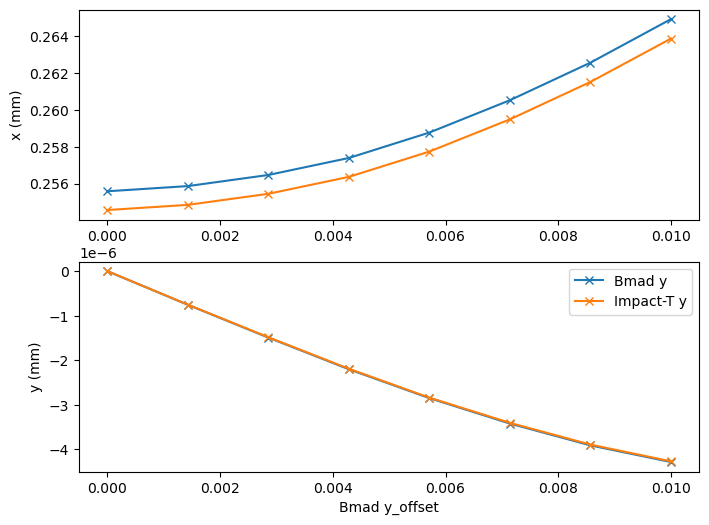

In [11]:
%%time
key = "y_offset"
values = np.linspace(0, 0.01, 8)
table = scan1(key, values)
table["values"] = values
table["key"] = key
plot_results(table)

In [12]:
%%time
key = "x_pitch"
values = np.linspace(0, 0.1, 8)
table = scan1(key, values)
table["values"] = values
table["key"] = key
plot_results(table)

CPU times: user 9.18 s, sys: 264 ms, total: 9.45 s
Wall time: 13.1 s


In [13]:
%%time
key = "y_pitch"
values = np.linspace(0, 0.1, 8)
table = scan1(key, values)
table["values"] = values
table["key"] = key
plot_results(table)

CPU times: user 9.08 s, sys: 344 ms, total: 9.42 s
Wall time: 13.1 s


# Cleanup

In [14]:
os.remove("test_lat.bmad")